# Final Model
### add explanation here

First, functions were created for all differential equations in the system.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math

### Drug Release with Dissolution of Microneedle: 

In [2]:
#function for rate of drug released from dissolving microneedle
def eqn_rate_drug_release_MN (DRMN_time,theta,rho,h, cs, ct,beta, kd):
    A = rho*math.pi*(math.tan(theta))**2
    deltaZMN = (3*DRMN_time/A)**1/3
    area_DMN = math.pi*math.tan(theta)/math.cos(theta)*(h**2-deltaZMN**2)+math.pi*(deltaZMN**2)*(math.tan(theta)**2)
    dDRMNdt = beta*kd*area_DMN*(cs-((1-beta)/beta)*ct)
    return dDRMNdt

### Drug Release with Dissolution of Base Plate:

In [3]:
#function for baseplate drug release 
def eqn_rate_drug_release_BP(DRBP_time, rho, Bbp, ct, beta):
    deltaZBP = DRBP_time/(rho*Bbp**2)
    area_DBP = 4*Bbp*(hbp - deltaZBP) + Bbp**2
    dDRBPdt = beta*kd*area_DBP*(cs-((1-beta)/beta)*ct)
    return dDRBPdt

### Flux of Drug from Baseplate to Skin:

In [4]:
def eqn_rate_flux_drugBP_2skin (N, D, hderm, hbp, DRBP_time, Vbp, ct):
    dFDBPS = -(2*D*N*math.pi*r**2)/(hderm+hbp)*(DRBP_time/Vbp - ct)
    return dFDBPS

### Concentration of Drug in Skin:

In [5]:
def eqn_rate_drug_concentration_skin(N,Vs,gamma, dDRMNdt,dFDBPS, ct):
    dDCSdt = N/Vs*(dDRMNdt)+1/Vs*(dFDBPS)-gamma*ct
    return dDCSdt

#### Now we can define the system of ODEs. First let set up the variabes:

In [6]:
#list of constants here
theta = 1 #in radians (0 - 0.7853)
rho =  1 #in g/m3
h =  1 #in m
cs = 1 #in g/m3
beta = 1 #unitless 0-1
kd = 1 #m2/s
gamma = 10 #unitless
N = 10 #number of needles in patch
Vs = 1
dose = 1 #in ng
Vn = math.pi*math.tan(theta)**2*((h**3)/3)#total volume of microneedle
Vbp = 1 #volume baseplase
Bbp =1 #size of side base plate 
hbp = 1 #height of base pair
D = 1 #drug diffusivity
r = 1 #radius mn
hderm = 0.0001 #thickness of dermis in m
Clb = 1 #systemic clearance of drug
Qper = 1 #intercompartment mass transfer rate
Vper = 1

### Define system of ODES
Also, we know that the drug release from the device is limited to the maximum dosage. Here we will add if statements to make sure that the drug release rate stays at zero when the maximum dosage is released from microneedles and baseplate. 

In [7]:
#add controls here to halt release once all drug has been released
controlMN = dose*Vn/(N*Vn+Vbp)
controlBP = dose*(1-N*Vn/(N*Vn+Vbp))

In [10]:
def system_of_odes(t,y):
    DRMN_time, DRBP_time, DFBPS_time, DCS_time = y
    #y is a vector where y[0] = DRMN_time, y[1] = DRBP_time, y[2] = DFBPS_time, y[3] = DCS_time
    dDRMNdt = eqn_rate_drug_release_MN (DRMN_time,theta,rho,h, cs, DCS_time, beta, kd)
    if DRMN_time >= controlMN:
        dDRMNdt = 0
    dDRBPdt = eqn_rate_drug_release_BP(DRBP_time, rho, Bbp, DCS_time, beta)
    if DRBP_time >= controlBP:
         dDRBPdt = 0
    dFDBPS = eqn_rate_flux_drugBP_2skin (N, D, hderm, hbp, DRBP_time, Vbp, DCS_time)
    if DRBP_time >= controlBP:
         dFDBPS = 0
    dDCSdt = eqn_rate_drug_concentration_skin(N,Vs,gamma, dDRMNdt,dFDBPS, DCS_time)
    return [dDRMNdt,dDRBPdt,dFDBPS,dDCSdt]


In [11]:
y0 = [0, 0, 0, 0]
t_span = (0, 2.5)
t_eval = np.linspace(0,2.5,10)
sol = solve_ivp(system_of_odes, t_span, y0, t_eval=t_eval)

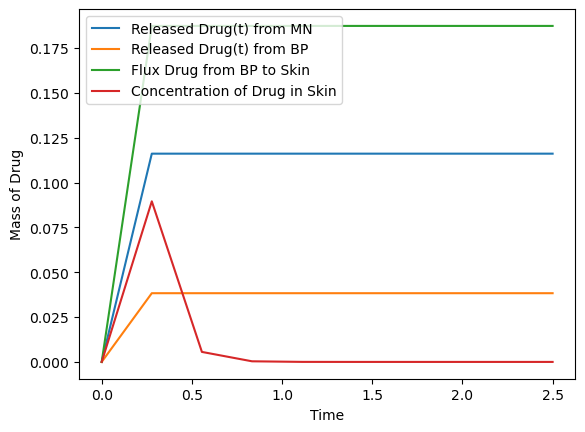

In [ ]:
plt.plot(sol.t, sol.y[0], label='Released Drug(t) from MN')
plt.plot(sol.t, sol.y[1], label='Released Drug(t) from BP')
plt.plot(sol.t, sol.y[2], label='Flux Drug from BP to Skin')
plt.plot(sol.t, sol.y[3], label='Concentration of Drug in Skin')
plt.xlabel('Time')
plt.ylabel('Mass of Drug')
plt.legend()
plt.show()

### Calculatinf Drug Concentration in Plasma

In [13]:
def eqn_change_DCP(DCS_time, Vs, Vbp, gamma, Clb,DPC_time, Qper,DCPer_time):
    dDCPdt = Vs/Vbp*gamma*DCS_time - 1/Vbp*(Clb*DPC_time) + Qper* DCPer_time
    return dDCPdt 

### Equation for Drug Concentration in Peripheral Compartments 

In [14]:
def eqn_change_DCPer(Vper, Qper, DCP_time, DCPer_time):
    dDCPerdt = 1/Vper*(Qper* DCP_time - Qper*DCPer_time)
    return dDCPerdt

### Create System of ODES to solve for Plasma Concentration

In [17]:

def system_of_ode_plasma(t2,x):
     DCP_time, DCPer_time= x
     dDCPdt = eqn_change_DCP(sol.y[3], Vs, Vbp, gamma, Clb,DCP_time, Qper,DCPer_time)
     dDCPerdt= eqn_change_DCPer(Vper, Qper, DCP_time, DCPer_time)
     return [dDCPdt, dDCPerdt]

In [18]:
x0 = [0, 0, 0, 0]
t_span2 = (0, 2.5)
t_eval2 = np.linspace(0,2.5,10)
sol = solve_ivp(system_of_ode_plasma, t_span2, x0, t_eval2=t_eval2)

/opt/miniconda3/envs/comp_mod_class/lib/python3.13/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `t_eval2`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


ValueError: too many values to unpack (expected 2)

In [ ]:
plt.plot(sol.t2, sol.y[0], label='Concentration Plasma')
plt.plot(sol.t2, sol.y[1], label='Concentration Peripheral')
plt.xlabel('Time')
plt.ylabel('Concentration of Drug')
plt.legend()
plt.show()